In [21]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import mne
import numpy as np
from pathlib import Path
import pandas as pd
from tqdm import tqdm


In [22]:
dir_data = Path(r'W:\source_projects\stepUp_jw\data\lab') # update the path to your folder

# find all vdhr files in any subfolder
fnames_bv_all = list(dir_data.glob('**/*.vhdr'))

# prelocate dataframe with channel names (0-127) as and impedances,
# column should be the time of the recordings
impedances_df = pd.DataFrame(columns=range(125))

# add date column
impedances_df['date'] = None



In [23]:

# loop over all vdhr files and save the plots for the impedance
for fname_bv in tqdm(fnames_bv_all):
    
    fname_bv = str(fname_bv)
    raw = mne.io.read_raw_brainvision(fname_bv, verbose=False, preload=True);
    # check if bva got the correct channel locations
    chns_layout = raw.get_montage()
    
    # get channel names
    ch_names = raw.ch_names
    
    # get impedances from eeg channels
    eeg_chs = mne.pick_types(raw.info, meg=False, eeg=True)
    all_imp = [info["imp"] for i, info in raw.impedances.items() if i != "ECG" or i != "33"]

    # typically impedances < 25 kOhm are acceptable for active systems and
    # impedances < 5 kOhm are desirable for a passive system
    impedances = [imp for imp in all_imp if not np.isnan(imp)]
    
    # add the impedances to the dataframe as one row
    impedances_df = pd.concat([impedances_df, pd.Series(impedances).to_frame().T], ignore_index=True)
    
    # add the date of the recording as a column name
    date_recording = raw.info['meas_date']
    impedances_df.loc[impedances_df.index[-1], 'date'] = date_recording


  0%|          | 0/31 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_29448\3493064948.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  impedances_df = pd.concat([impedances_df, pd.Series(impedances).to_frame().T], ignore_index=True)
100%|██████████| 31/31 [04:00<00:00,  7.74s/it]


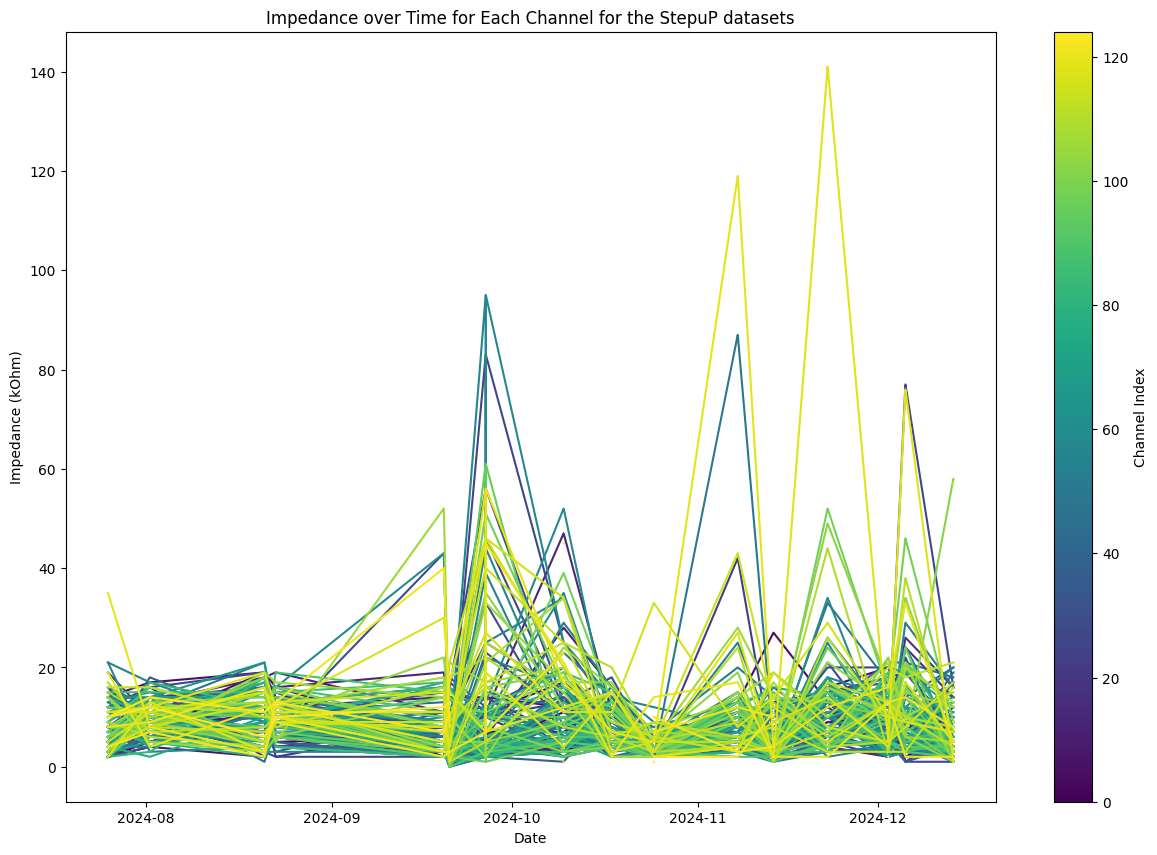

In [24]:

# order df by date
impedances_df = impedances_df.sort_values('date')

# drop row if more than half are nan values
impedances_df = impedances_df.dropna(thresh=impedances_df.shape[1]//2)

# plot the impedances against date for each channel
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=124)

for i in range(125):
    ax.plot(impedances_df['date'], impedances_df[i], label=f'Channel {i}', color=cmap(norm(i)))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Channel Index')

ax.set_xlabel('Date')
ax.set_ylabel('Impedance (kOhm)')
ax.set_title('Impedance over Time for Each Channel for the StepuP datasets')
plt.show()

In [25]:
# Get today's date
today_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# Define the filename with today's date
filename = f'impedance_checks/impedances_stepup_{today_date}.csv'

# Save the dataframe to a CSV file
impedances_df.to_csv(filename, index=False)

In [28]:
impedances_df['date']

30    2024-07-25 16:07:42.468603+00:00
12    2024-08-01 15:52:27.135575+00:00
13    2024-08-01 16:03:56.464836+00:00
0     2024-08-20 18:31:49.652449+00:00
1     2024-08-20 18:38:42.978002+00:00
14    2024-08-22 15:19:34.532171+00:00
15    2024-08-22 15:30:52.561280+00:00
6     2024-09-19 16:05:26.228353+00:00
7     2024-09-19 16:15:17.856301+00:00
8     2024-09-20 14:58:44.821443+00:00
22    2024-09-26 15:49:50.365880+00:00
23    2024-09-26 16:14:03.585403+00:00
16    2024-10-09 15:32:30.740879+00:00
17    2024-10-09 15:45:08.331058+00:00
26    2024-10-17 15:44:08.341561+00:00
27    2024-10-17 15:55:44.950920+00:00
18    2024-10-24 16:21:41.105909+00:00
19    2024-10-24 16:30:38.613130+00:00
20    2024-11-07 16:15:39.466518+00:00
21    2024-11-07 16:27:18.295907+00:00
4     2024-11-13 15:19:45.816591+00:00
5     2024-11-13 15:35:44.429470+00:00
2     2024-11-22 15:48:14.304171+00:00
3     2024-11-22 15:58:48.492691+00:00
10    2024-12-02 18:42:20.104173+00:00
11    2024-12-02 18:50:58

KeyError: 'date'

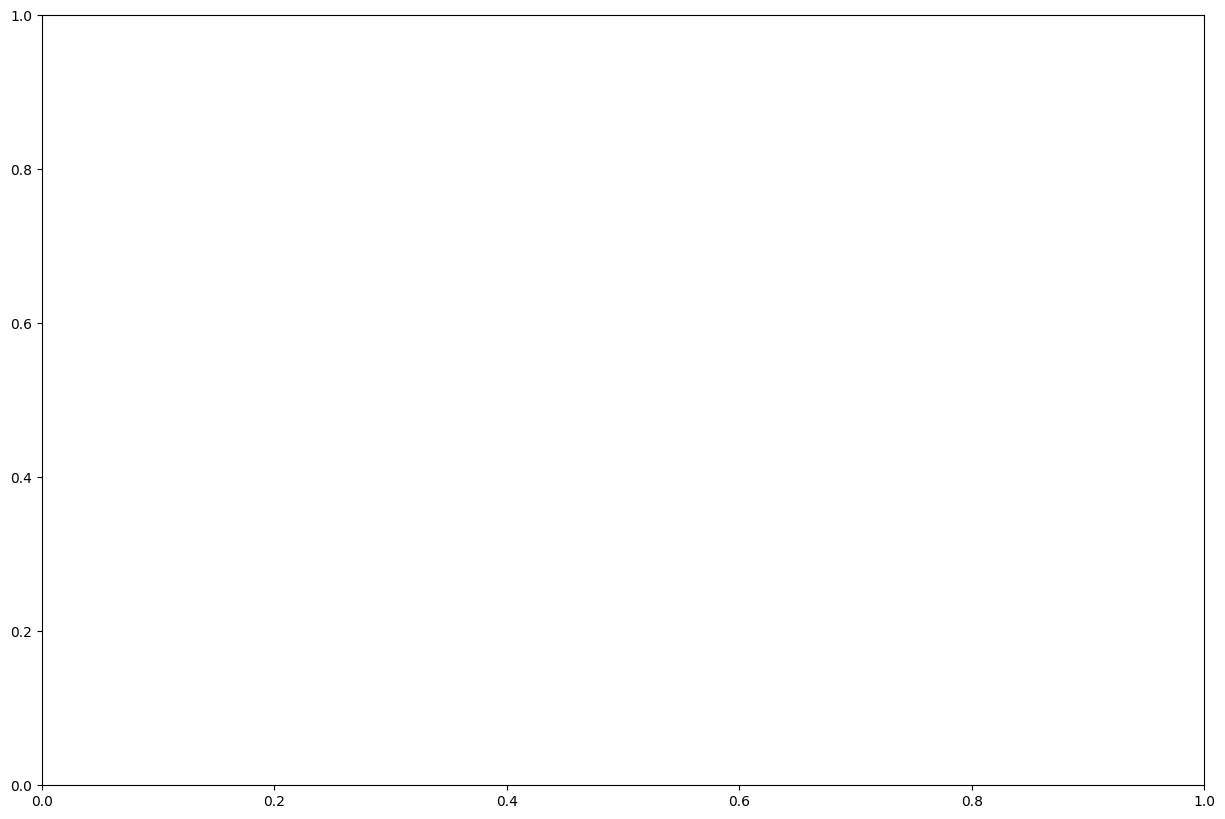

In [ ]:
percentiles = [0.70, 0.80, 0.90, 0.95]

# load df
impedances_df = pd.read_csv(filename)

# convert 'date' column to datetime
impedances_df['date'] = pd.to_datetime(impedances_df['date'])

# plot percentiles over time
fig, ax = plt.subplots(figsize=(15, 10))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=124)

for i in range(125):
    ax.plot(impedances_df['date'], impedances_df[i], label=f'Channel {i}', color=cmap(norm(i)))

    for percentile in percentiles:
        percentile_value = impedances_df[i].quantile(percentile)
        ax.plot(impedances_df['date'], [percentile_value]*len(impedances_df['date']), label=f'Channel {i} {percentile*100:.0f}th percentile', color=cmap(norm(i)), linestyle='--')


